In [27]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tt
from torchvision.datasets import CIFAR100
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

## Load MoCo pretrained Resnet50

In [28]:
model = torchvision.models.resnet50()
state_dict = torch.load('moco_v2_800ep_pretrain.pth.tar', map_location='cpu')['state_dict']
for k in list(state_dict.keys()):
    # retain only encoder_q up to before the embedding layer
    if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
        # remove prefix
        state_dict[k[len("module.encoder_q."):]] = state_dict[k]
    # delete renamed or unused k
    del state_dict[k]

msg = model.load_state_dict(state_dict, strict=False)
assert set(msg.missing_keys) == {"fc.weight", "fc.bias"}

In [29]:
for name, param in model.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False
# init the fc layer
model.fc.weight.data.normal_(mean=0.0, std=0.01)
model.fc.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [30]:
stats = ((0.5074, 0.4867, 0.4411), (0.2011, 0.1987, 0.2025))
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [31]:
test_data = CIFAR100(root="./data",train=False,transform=test_transform, download=True)

Files already downloaded and verified


In [32]:
test_classes_items = dict()
for test_item in test_data:
    label = test_data.classes[test_item[1]]
    if label not in test_classes_items:
        test_classes_items[label] = 1
    else:
        test_classes_items[label] += 1

test_classes_items

{'mountain': 100,
 'forest': 100,
 'seal': 100,
 'mushroom': 100,
 'sea': 100,
 'tulip': 100,
 'camel': 100,
 'butterfly': 100,
 'cloud': 100,
 'apple': 100,
 'skunk': 100,
 'streetcar': 100,
 'rocket': 100,
 'lamp': 100,
 'lion': 100,
 'wolf': 100,
 'rose': 100,
 'orange': 100,
 'dinosaur': 100,
 'chimpanzee': 100,
 'can': 100,
 'keyboard': 100,
 'bicycle': 100,
 'chair': 100,
 'plate': 100,
 'lawn_mower': 100,
 'turtle': 100,
 'palm_tree': 100,
 'shark': 100,
 'pickup_truck': 100,
 'boy': 100,
 'couch': 100,
 'house': 100,
 'porcupine': 100,
 'cockroach': 100,
 'clock': 100,
 'castle': 100,
 'beaver': 100,
 'bee': 100,
 'bottle': 100,
 'pear': 100,
 'baby': 100,
 'flatfish': 100,
 'oak_tree': 100,
 'leopard': 100,
 'snail': 100,
 'crocodile': 100,
 'rabbit': 100,
 'beetle': 100,
 'girl': 100,
 'sunflower': 100,
 'raccoon': 100,
 'train': 100,
 'ray': 100,
 'trout': 100,
 'bowl': 100,
 'snake': 100,
 'orchid': 100,
 'tractor': 100,
 'caterpillar': 100,
 'bus': 100,
 'mouse': 100,
 'cr

In [33]:
BATCH_SIZE=16
test_dl = DataLoader(test_data,BATCH_SIZE,num_workers=0,pin_memory=True)

In [34]:
def show_batch(dl):
    for batch in dl:
        images, labels = batch
        fig, ax = plt.subplots(figsize=(7.5, 7.5))
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(make_grid(images[:16], nrow=4).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


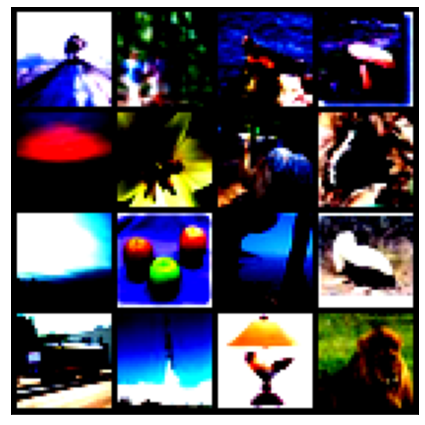

In [35]:
show_batch(test_dl)

In [36]:
def accuracy(predicted,actual):
    _, predictions = torch.max(predicted,dim=1)
    return torch.tensor(torch.sum(predictions==actual).item()/len(predictions))

In [37]:
model.eval()
accs = []
for imgs, gts in test_dl:
    preds = model(imgs)
    accs.append(accuracy(preds, gts))
print(sum(accs)/len(accs))

tensor(0.0010)
